## Random Forest

#### Table of Contents

- [Preliminaries](#Preliminaries)
- [Null Model](#Null-Model)
- [Decision Tree](#Decision-Tree)
- [Bagging](#Bagging)
- [Random Forest](#Random-Forest)
- [Comparison](#Comparison)

First, let's create some functions to help us in the future.

In [1]:
%run metrics.py

In [2]:
%whos

Variable   Type        Data/Info
--------------------------------
acc        function    <function acc at 0x0000021BF3B52310>
rmse       function    <function rmse at 0x0000021BF3B523A0>


***********
# Preliminaries
[TOP](#Random-Forest)

We will be comparing three models predicting the label `urate_bin`

1. decision tree
2. bagged decision trees
3. random forest

Loading the packages and prepping the data.

In [2]:
# utilities

import pandas as pd

# processing

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

# algorithms

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# plotting

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_pickle('C:/Users/hubst/Econ490_group/class_data.pkl')

In [4]:
y = df['urate_bin'].astype('category')
x = df.drop(columns = ['urate_bin', 'GeoName'])

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size = 2/3, 
                                                    random_state = 490)

****
# Null Model
[TOP](#Random-Forest)

In [5]:
y_train

fips   year
55033  2005     higher
8039   2010      lower
42047  2018    similar
28145  2011     higher
40127  2003     higher
                ...   
39003  2005     higher
48437  2014    similar
48305  2009      lower
48051  2017    similar
45009  2009     higher
Name: urate_bin, Length: 33418, dtype: category
Categories (3, object): ['higher', 'lower', 'similar']

In [9]:
yhat_null = y_train.value_counts().index[0]
acc_null = acc(yhat_null, y_test)
acc_null

0.4348554671135316

****************
# Decision Tree
[TOP](#Random-Forest)

To compare the tree-based models, we are going to start with a single decision tree classifier.

In [11]:
param_grid = {
    'max_leaf_nodes': range(1, 40)
}

dtc_cv = DecisionTreeClassifier(random_state = 490)

grid_search = GridSearchCV(dtc_cv, param_grid,
                          cv = 5, 
                          scoring = 'accuracy',
                          n_jobs = 10, 
                          verbose = 2).fit(x_train, y_train)
best_dtc = grid_search.best_params_
best_dtc

Fitting 5 folds for each of 39 candidates, totalling 195 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 195 out of 195 | elapsed:    7.2s finished


{'max_leaf_nodes': 27}

In [13]:
clf_dtc = DecisionTreeClassifier(random_state = 490,
                                max_leaf_nodes = best_dtc['max_leaf_nodes'])
clf_dtc.fit(x_train, y_train)
acc_dtc = clf_dtc.score(x_test, y_test)
acc_dtc

0.6565324076844814

**********
# Bagging
[TOP](#Random-Forest)

Remember that bagged trees consider ALL features.

In [ ]:
BaggingClassifier?

In [15]:
clf_bc = BaggingClassifier(n_estimators = 500,
                          random_state = 490,
                          oob_score = True, 
                          n_jobs = 10, 
                          verbose = 1)
clf_bc.fit(x_train, y_train)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   19.6s remaining:  1.3min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   20.3s finished


BaggingClassifier(n_estimators=500, n_jobs=10, oob_score=True, random_state=490,
                  verbose=1)

In [16]:
clf_bc.oob_score_

0.7539948530731941

In [17]:
acc_bc = clf_bc.score(x_test, y_test)
acc_bc

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.6s remaining:    2.6s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.6s finished


0.7487581542881082

Alternatively...

In [18]:
clf_bag_tree = RandomForestClassifier(n_estimators = 500,
                          random_state = 490, 
                          max_features = None, 
                          oob_score = True, 
                          n_jobs = 10, 
                          verbose = 1)
clf_bag_tree.fit(x_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    7.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   17.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   19.6s finished


RandomForestClassifier(max_features=None, n_estimators=500, n_jobs=10,
                       oob_score=True, random_state=490, verbose=1)

In [19]:
clf_bag_tree.oob_score_

0.7530073613022922

In [20]:
acc_bag_tree = clf_bag_tree.score(x_test, y_test)
acc_bag_tree

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished


0.748039978454725

*********
# Random Forest
[TOP](#Random-Forest)


Let's see if we can beat the bagged model!

In [21]:
clf_rf = RandomForestClassifier(n_estimators = 500,
                          random_state = 490, 
                          max_features = 'sqrt', 
                          oob_score = True, 
                          n_jobs = 10, 
                          verbose = 1)
clf_rf.fit(x_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    2.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    6.2s finished


RandomForestClassifier(max_features='sqrt', n_estimators=500, n_jobs=10,
                       oob_score=True, random_state=490, verbose=1)

In [22]:
clf_rf.oob_score_

0.7551618888024418

In [23]:
acc_rf = clf_rf.score(x_test, y_test)
acc_rf

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished


0.7475013465796876

In [25]:
df_plot = pd.DataFrame(clf_rf.feature_importances_,
                      index = x_train.columns,
                      columns = ['Feature Importance']).sort_values(by = 'Feature Importance',
                                                                   ascending = False)

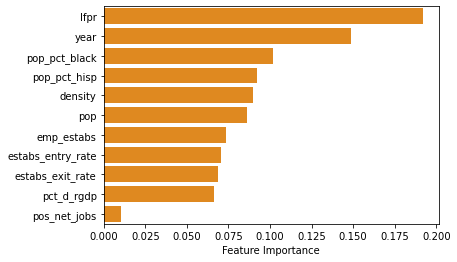

In [26]:
sns.barplot(data = df_plot,
           x = 'Feature Importance',
           y = df_plot.index,
           color = 'darkorange')
plt.show()

************
# Comparison
[TOP](#Random-Forest)

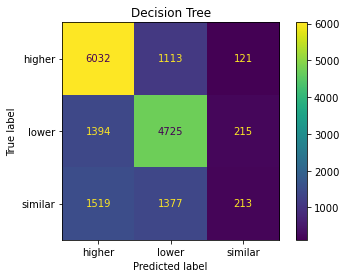

In [28]:
sk_fig = plot_confusion_matrix(clf_dtc, x_test, y_test)
plt.title('Decision Tree')
plt.show()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished


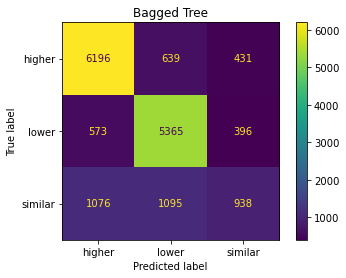

In [29]:
sk_fig = plot_confusion_matrix(clf_bag_tree, x_test, y_test)
plt.title('Bagged Tree')
plt.show()

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.2s finished


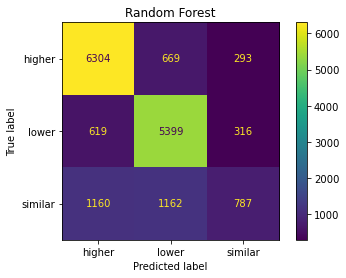

In [30]:
sk_fig = plot_confusion_matrix(clf_rf, x_test, y_test)
plt.title('Random Forest')
plt.show()

************
# `sklearn` is pretty cool

So, check this out!

In [38]:
classifiers = [DecisionTreeClassifier(max_leaf_nodes = best_dtc ['max_leaf_nodes']),
              BaggingClassifier(n_estimators = 100,
                                random_state = 490,
                                n_jobs = 10),
              RandomForestClassifier(n_estimators = 100,
                                     max_features = 'sqrt',
                                     n_jobs = 10,
                                     random_state = 490)]

In [39]:
%%time
for clf in classifiers:
    clf.fit(x_train, y_train)

Wall time: 9.36 s


In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 3,
                      figsize = (16, 4))
plt.close()

In [41]:
type(ax)
type(ax).__name__
ax.shape
ax[0]
ax
ax.flatten()
ax == ax.flatten()

array([ True,  True,  True])

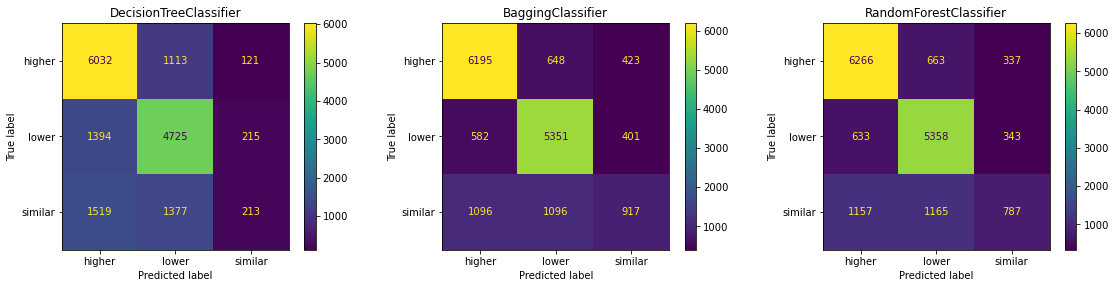

In [42]:
_, ax = plt.subplots(nrows = 1, ncols = 3,
                    figsize = (16, 4))

for clf, axis in zip(classifiers, ax.flatten()):
    plot_confusion_matrix(clf,
                         x_test,
                         y_test,
                         ax = axis)
    axis.title.set_text(type(clf).__name__)
    
plt.tight_layout()